# Single-Image Super-Resolution on Grayscale Images
**Author:** [Richard Hemphill](mailto:rhemphill2019@my.fit.ed)<br>
**School:** [Florida Institute of Technology](https://www.fit.edu/)<br>
**Class:** [ECE5268 Theory of Neural Networks](http://catalog.fit.edu/preview_course_nopop.php?catoid=1&coid=927&)<br>
**Instructor:** [Dr. Georgios C. Anagnostopoulos](https://www.fit.edu/faculty-profiles/3/georgios-anagnostopoulos/)<br>
**Assignment:** Individual Class Project<br>

# Table of Contents
1. [Concept](#Concept)
    1. [Description](#Concept-Description)
    1. [Goal](#Concept-Goal)
1. [References](#References)
    1. [Architecture](#References-Architecture)
    1. [Dataset](#References-Dataset)
    1. [Example](#References-Example)
1. [Architecture](#Architecture)
1. [Code](#Code)
    1. [Configure](#Code-Configure)
    1. [Utility](#Code-Utility)
    1. [Prepocessing](#Code-Prepocessing)
    1. [Model](#Code-Model)
    1. [Test](#Code-Test)
1. [Results](#Results)

# Concept<a class="anchor" id="Concept"></a>

## Description<a class="anchor" id="Concept-Description"></a>
Using small-sized grayscale images, construct a neural network architecture that will magnify and enhance the images by a factor of 2.  The following image shows the concept where a magnified image maintains the reduces resolution and thus blurry.  A neural network can be trained to enhance features in the image (i.e. super resolution) so that it looks close to the original.

![description](figures/description.png)

## Goal<a class="anchor" id="Concept-Goal"></a>
The goal of the project is to construct Python code to import and extract a dataset, take shrunken images with the original and train a CNN (Convolutional Neural Network) to magnify and subsequently enhance an image back to the original as shown in the following figure.

![goal](figures/goal.png)


# References<a name="References"></a>

## Architecute<a name="References-Architecute"></a>
The following paper is a trade study to show that a lightweigh structure can perform to a more deeper (i.e. more layers) network.  If trained sufficiently, it can outperform classical magnification (e.g. bicubic interpolation). 
> C. Dong, C. C. Loy, K. He and X. Tang, "[Image Super-Resolution Using Deep Convolutional Networks](https://ieeexplore.ieee.org/document/7115171)," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 38, no. 2, pp. 295-307, 1 Feb. 2016, doi: 10.1109/TPAMI.2015.2439281.

## Dataset<a name="References-Dataset"></a>
The following [Kaggle](https://www.kaggle.com/) dataset contains about 800 taining and 260 test images.  They are all greyscale and there is no license on the images.  It shows how to produce a model to perform super resolution.
> Goose, Mr. “AlexOnly_Greyscale,” January 22, 2020. https://www.kaggle.com/spaceengineer1/alexonly-greyscale.

The following walk through explains how to access Kaggle datasets from jupyter notebook.
> Daniel, Jeff. Medium. Accessed April 11, 2021. https://medium.com/@jeff.daniel77/accessing-the-kaggle-com-api-with-jupyter-notebook-on-windows-d6f330bc6953. 



## Example<a name="References-Example"></a>
The following example code came from the [Keras code examples](https://keras.io/examples/).  
> Long, Xingyu. “Image Super-Resolution Using an Efficient Sub-Pixel CNN,” 2020. https://keras.io/examples/vision/super_resolution_sub_pixel/. 

# Architecture<a class="anchor" id="Architecture"></a>
The model: creates feature maps of the low-resolution image, increases the dimensionality (i.e. number of nodes in a layer), then reconstructs the expected high-resolution image.

![architecture](figures/architecture.png)

# Code<a class="anchor" id="Code"></a>

## Configure<a class="anchor" id="Code-Configure"></a>

### Imports

In [1]:
# General
import time
import math
import random
from datetime import timedelta

# Path
import os.path
import shutil
import glob
from zipfile import ZipFile

# Math
import numpy as np

# Image
from pylab import rcParams
import matplotlib.pyplot as plt
from PIL.Image import BICUBIC
import imageio

# Dataset
from kaggle.api.kaggle_api_extended import KaggleApi

# Model
from tensorflow import keras
from tensorflow.test import gpu_device_name
from tensorflow.image import resize
from tensorflow.image import ResizeMethod
from tensorflow.image import psnr
from tensorflow.nn import depth_to_space
from keras.models import load_model
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

### Constants

In [2]:
# training parameters
EPOCHS = 1000
BATCH_SIZE = 10
VALIDATION_SPLIT = 0.2

# largest integer use for seeding the random number generator
RANDRANGE_STOP = 1000

# data set parameters
IMAGE_SET_OWNER = 'spaceengineer1'
IMAGE_SET_FILE = 'alexonly-greyscale'
ZIP_EXTENSION = 'zip'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'
NUM_TRAIN_PROGRESS = 100
EPOCH_SAMPLE_PROGRESS = EPOCHS / NUM_TRAIN_PROGRESS

# image parameters
IMAGE_EXTENSION = 'jpg'
RESCALE_FACTOR = 255.0  # normalize pixels
CHANNELS = 1            # greyscale
ORIG_IMG_SIZE = 64     # baseline size
UPSCALE_FACTOR = 2      # magnification factor
LOW_RES_IMG_SIZE = int(ORIG_IMG_SIZE/UPSCALE_FACTOR)

# directoryies
CURRENT_DIRECTORY = '.'
FIGURE_DIRECTORY = 'figures'
MODEL_DIRECTORY = 'variables'
SAMPLE_DIRECTORY = 'samples'

# results
TRAINING_PLOT = 'SuperResTrain.png'
TEST_RESULT = 'TestSetExample.png'
SAMPLE_MOVIE = 'SampleMovie.gif'

# print format
FORMAT_BOLD = '\033[1m'
FORMAT_RED = '\033[91m'
FORMAT_END = '\033[0;0m'

### Setup

In [3]:
# set figure's width 8 inches, and its height 8 inches
rcParams['figure.figsize'] = 8, 8

In [4]:
# Check if Tensorflow is using GPU
if gpu_device_name():
    print('Default GPU Device: {}'.format(gpu_device_name()))
else:
    print("Please install GPU version of TensorFlow")

Default GPU Device: /device:GPU:0


## Utility<a class="anchor" id="Code-Utility"></a>

In [5]:
# Rescale each pixel in the image so that intensity gets converted from 0-255 to 0.0-1.0
def ImageNorm(img):
    img = img/RESCALE_FACTOR
    return img

In [6]:
# Create a reduced scale image of the original
def Shrink(img, size=LOW_RES_IMG_SIZE):
    return resize(img,[size,size])

In [7]:
# Create an increased scale image back to the original using bicubic interpolation.
def Magnify(img, size=ORIG_IMG_SIZE):
    return resize(img,[size,size],method=ResizeMethod.BICUBIC)

In [8]:
# Create an image that has been shrunk then magnified for enhancement.
def PreProcess(img):
    return Magnify(Shrink(img))

In [9]:
# Create an increased scale image using super-resoluton model
def EnhanceImage(model, img, size=ORIG_IMG_SIZE, channels=CHANNELS):
    arr = img_to_array(img)
    arr = arr.astype('float32')/RESCALE_FACTOR
    arr = np.expand_dims(arr, axis=0)
    predArr = model.predict(arr)
    predArr *= RESCALE_FACTOR
    predArr = predArr.reshape((size,size,channels))
    enhancedImg = array_to_img(predArr)
    return enhancedImg

In [10]:
# Extract raw image set
def DownloadImageSet(imageSetOwner = IMAGE_SET_OWNER, imageSetFile = IMAGE_SET_FILE):
    zipFile = '{}.{}'.format(imageSetFile, ZIP_EXTENSION)
    if not os.path.isfile(zipFile):
        # connect to the Kaggle Database and download dataset
        api = KaggleApi()
        api.authenticate()
        api.dataset_download_files('{}/{}'.format(imageSetOwner, imageSetFile))
    # extract the dataset
    zf = ZipFile(zipFile)
    topDir = ''.join({item.split('/')[0] for item in zf.namelist()})
    if not os.path.isdir(topDir):
        zf.extractall() 
        zf.close()

    testDirPre = os.path.join(topDir,TEST_FOLDER)
    if os.path.exists(testDirPre):
        if not os.path.exists(TEST_FOLDER):
            shutil.move(testDirPre, CURRENT_DIRECTORY)
        
    return topDir, TEST_FOLDER

## Prepocessing<a class="anchor" id="Code-Prepocessing"></a>

In [11]:
# Pre Process Images
trainFolder, testFolder = DownloadImageSet()

In [12]:
# list the test images
testImgPaths = glob.glob('{}/*.{}'.format(testFolder, IMAGE_EXTENSION))

In [13]:
# take a sample from the test images
sampleIdx = random.randrange(len(testImgPaths))
sampleFile = testImgPaths[sampleIdx]
sampleImg = load_img(sampleFile, color_mode='grayscale', target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
sampleLowResImg = sampleImg.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE))
sampleBiCubicImg = sampleLowResImg.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=BICUBIC)

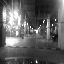

Sample Test Image: test\1590.jpg


In [14]:
# info about sample image
display(sampleImg)
print('Sample Test Image: {}'.format(sampleFile))
samplePsnr = psnr(img_to_array(sampleBiCubicImg), img_to_array(sampleImg), max_val=255)

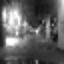

Interpolated PSNR: 23.9


In [15]:
# info about interpolated image
display(sampleBiCubicImg)
print('Interpolated PSNR: {:.3}'.format(samplePsnr))

In [16]:
trainSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='training',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 644 files for training.


In [17]:
trainSet = trainSet.map(ImageNorm)
trainSet = trainSet.map(lambda x: (PreProcess(x),x))

In [18]:
valSet = image_dataset_from_directory(
    directory=trainFolder,
    batch_size=BATCH_SIZE,
    image_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE),
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    color_mode='grayscale',
    seed=random.randrange(RANDRANGE_STOP),
    label_mode=None)

Found 804 files belonging to 1 classes.
Using 160 files for validation.


In [19]:
valSet = valSet.map(ImageNorm)
valSet = valSet.map(lambda x: (PreProcess(x),x))

## Model<a class="anchor" id="Code-Model"></a>

In [20]:
class SuperCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        # Initialize the lists for holding the logs, losses and accuracies
        self.loss = []
        self.valLoss = []
        self.psnr = []
        self.sampleImg = sampleBiCubicImg
        self.sampleNum = 0
        if not os.path.exists(SAMPLE_DIRECTORY):
            os.mkdir(SAMPLE_DIRECTORY)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnrEpoch = []

    # Print result of PNSR per Epoch
    def on_epoch_end(self, epoch, logs=None):
        # Append the logs, losses and accuracies to the lists
        self.loss.append(logs.get('loss'))
        self.valLoss.append(logs.get('val_loss'))
        self.psnr.append(np.mean(self.psnrEpoch))
        # Sample images as the model is being trained
        if (epoch % EPOCH_SAMPLE_PROGRESS) == 0:
            enhanced = EnhanceImage(self.model, self.sampleImg)
            enhancedPsnr = psnr(img_to_array(enhanced), img_to_array(sampleImg), 
                max_val=255)
            print('{}{}Epoch({}) PSNR({:.3}){}'.format(FORMAT_BOLD, 
                FORMAT_RED, epoch, enhancedPsnr,FORMAT_END))
            enhanced.save('{}/s{:0>3}.{}'.format(SAMPLE_DIRECTORY, 
                self.sampleNum, IMAGE_EXTENSION))
            self.sampleNum += 1

    # Aggregate PNSR per batch run
    def on_test_batch_end(self, batch, logs=None):
        self.psnrEpoch.append(10 * math.log10(1 / logs["loss"]))

    def on_train_end(self, logs=None):
        # Before plotting ensure at least 2 epochs have passed
        if len(self.loss) > 1:
            # plot the metric
            N = np.arange(0, len(self.loss))
            fig, ax = plt.subplots()
            ax.plot(N, self.loss, label='Train Loss', color='blue')
            ax.plot(N, self.valLoss, label='Val Loss', color='red')
            ax.set_ylabel("Loss")
            ax.legend(loc='upper left')
            ax2=ax.twinx()
            ax2.plot(N, self.psnr, label='PSNR', color='green')
            ax2.set_ylabel('Peak Signal to Noise Ratio')
            ax2.legend(loc='upper right')
            ax.set_xlabel("Epoch #")
            plt.savefig('{}/{}'.format(FIGURE_DIRECTORY, TRAINING_PLOT))
            plt.close()
            # animate the training
            sampleImgs = glob.glob('{}/*.{}'.format(SAMPLE_DIRECTORY, IMAGE_EXTENSION))
            images = []
            for sampleImg in sampleImgs:
                images.append(imageio.imread(sampleImg))
            imageio.mimsave('{}/{}'.format(FIGURE_DIRECTORY, SAMPLE_MOVIE), images)

In [21]:
def SuperResolution(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    conv2dArgs = {"activation": "relu",
        "bias_initializer": "zeros",
        "padding": "same"}

    #kernInit = initializers.RandomNormal(mean=0.0, stddev=0.001)
    kernInit = initializers.Orthogonal()

    inputs = keras.Input(shape=(None, None, channels))

    patchExtract = keras.layers.Conv2D(filters=64, kernel_size=9,
        kernel_initializer=kernInit,
        **conv2dArgs)(inputs)

    nonLinearMap = keras.layers.Conv2D(filters=32, kernel_size=1, 
        kernel_initializer=kernInit,
        **conv2dArgs)(patchExtract)

    reconstruction = keras.layers.Conv2D(filters=1, kernel_size=5, 
        kernel_initializer=kernInit,
        **conv2dArgs)(nonLinearMap)

    return keras.Model(inputs, reconstruction)

In [22]:
def KerasExample(upscaleFactor=UPSCALE_FACTOR, channels=CHANNELS):

    conv2dArgs = {"activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same"}

    inputs = keras.Input(shape=(None, None, channels))

    patchExtract1 = keras.layers.Conv2D(filters=64, kernel_size=5,
        **conv2dArgs)(inputs)

    patchExtract2 = keras.layers.Conv2D(filters=64, kernel_size=3, 
        **conv2dArgs)(patchExtract1)

    patchExtract3 = keras.layers.Conv2D(filters=32, kernel_size=3, 
        **conv2dArgs)(patchExtract2)

    reconstruction = keras.layers.Conv2D(filters=1, kernel_size=3, 
        **conv2dArgs)(patchExtract3)

    return keras.Model(inputs, reconstruction)

In [23]:
# load or train model
tic = time.time()
if os.path.exists(MODEL_DIRECTORY):
    # to force a re-training, delete the assets and variables folder
    sr = load_model(CURRENT_DIRECTORY)
else:
    #sr = SuperResolution()
    sr = KerasExample()
    sr.compile(optimizer=keras.optimizers.SGD(learning_rate=1E-3), 
        loss=keras.losses.MeanSquaredError())
    sr.fit(trainSet, epochs=EPOCHS, callbacks=[SuperCallback()], 
        validation_data=valSet, use_multiprocessing=True, verbose=0)
    sr.save(CURRENT_DIRECTORY)
trainTime = time.time()-tic
sr.summary()

Epoch(0) PSNR(19.5)
Epoch(10) PSNR(19.7)
Epoch(20) PSNR(19.8)
Epoch(30) PSNR(19.9)
Epoch(40) PSNR(20.0)
Epoch(50) PSNR(20.0)
Epoch(60) PSNR(20.0)
Epoch(70) PSNR(20.1)
Epoch(80) PSNR(20.1)
Epoch(90) PSNR(20.1)
Epoch(100) PSNR(20.1)
Epoch(110) PSNR(20.2)
Epoch(120) PSNR(20.2)
Epoch(130) PSNR(20.2)
Epoch(140) PSNR(20.2)
Epoch(150) PSNR(20.2)
Epoch(160) PSNR(20.2)
Epoch(170) PSNR(20.2)
Epoch(180) PSNR(20.1)
Epoch(190) PSNR(20.1)
Epoch(200) PSNR(20.0)
Epoch(210) PSNR(19.9)
Epoch(220) PSNR(19.9)
Epoch(230) PSNR(19.8)
Epoch(240) PSNR(19.8)
Epoch(250) PSNR(19.7)
Epoch(260) PSNR(19.6)
Epoch(270) PSNR(19.6)
Epoch(280) PSNR(19.5)
Epoch(290) PSNR(19.5)
Epoch(300) PSNR(19.5)
Epoch(310) PSNR(19.5)
Epoch(320) PSNR(19.6)
Epoch(330) PSNR(19.6)
Epoch(340) PSNR(19.6)
Epoch(350) PSNR(19.6)
Epoch(360) PSNR(19.6)
Epoch(370) PSNR(19.7)
Epoch(380) PSNR(19.7)
Epoch(390) PSNR(19.7)
Epoch(400) PSNR(19.8)
Epoch(410) PSNR(19.8)
Epoch(420) PSNR(19.8)
Epoch(430) PSNR(19.9)
Epoch(440) PSNR(19.9)
Epoch(450) PSNR(19.9)

## Test<a class="anchor" id="Code-Test"></a>
Test the model against a set of test images.

In [24]:
# create an image that shows the test results
def TestImg(testImg,lowResImg,biCubicImg,superResImg):
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(testImg,cmap='gray')
    ax1.set_title('Test Image')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(lowResImg,cmap='gray')
    ax2.set_title('Low Res Image')
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(biCubicImg,cmap='gray')
    ax3.set_title('Bicubic Image')
    ax4 = fig.add_subplot(2,2,4)
    ax4.imshow(superResImg,cmap='gray')
    ax4.set_title('Super Res Image')
    plt.savefig('{}/{}'.format(FIGURE_DIRECTORY, TEST_RESULT))
    plt.close()

In [25]:
# Determine the peak signal-to-noise ration of the super resolution set and compare again classical magnification.
totalBiCubicPsnr = 0
totalSuperPsnr = 0
totalEnhancingTime = 0

for idx, testImgPath in enumerate(testImgPaths):
    img = load_img(testImgPath, color_mode='grayscale', 
        target_size=(ORIG_IMG_SIZE,ORIG_IMG_SIZE))
        
    lowResImg = img.resize((LOW_RES_IMG_SIZE,LOW_RES_IMG_SIZE))
    biCubicImg = lowResImg.resize((ORIG_IMG_SIZE,ORIG_IMG_SIZE), resample=BICUBIC)
    tic = time.time()
    superResImg = EnhanceImage(sr,biCubicImg)
    enhancingTime = time.time() - tic

    biCubicPsnr = psnr(img_to_array(biCubicImg), img_to_array(img), max_val=255)
    superPsnr = psnr(img_to_array(superResImg), img_to_array(img), max_val=255)

    totalBiCubicPsnr += biCubicPsnr
    totalSuperPsnr += superPsnr
    totalEnhancingTime += enhancingTime

In [26]:
sampleSuperResImg = EnhanceImage(sr,sampleBiCubicImg)
TestImg(sampleImg,sampleLowResImg,sampleBiCubicImg,sampleSuperResImg)

# Results<a class="anchor" id="Results"></a>

As the model is trained, the image quality improves.  The validation loss converges close to the training loss (i.e. no overfitting).
![Training Plot](figures/SuperResTrain.png)

Images get processed over epochs to become clearer.

<img src="figures/SampleMovie.gif" width="300" height="300">

![Test Set Example](figures/TestSetExample.png)

In [27]:
print('Magnify (BiCubic) PSNR: {:.3}'.format(totalBiCubicPsnr/(idx+1)))
print('Super Resolution PSNR: {:.3}'.format(totalSuperPsnr/(idx+1)))
print('Training Time ({} epochs): {:0>8}'.format(EPOCHS, str(timedelta(seconds = trainTime))))
print('Enhancing Time: {:.3} ms'.format(1000*(totalEnhancingTime/(idx+1))))

Magnify (BiCubic) PSNR: 25.1
Super Resolution PSNR: 20.3
Training Time (1000 epochs): 2:18:50.237811
Enhancing Time: 37.5 ms
